# Experiment Management with Aim

This tutorial is based on a [tutorial](https://github.com/osoblanco/tutorials/blob/master/3d_segmentation/spleen_segmentation_3d.ipynb) developed by the Aim team for MONAI, along with a blog post [here](https://aimstack.io/aim-monai-tutorial/).

This tutorial shows how to use common Aim functionalities to management MONAI experiments. The MONAI example used here is [3D spleen segmentation](https://github.com/Project-MONAI/tutorials/blob/main/3d_segmentation/spleen_segmentation_3d.ipynb).

![spleen](http://medicaldecathlon.com/img/spleen0.png)

Target: Spleen  
Modality: CT  
Size: 61 3D volumes (41 Training + 20 Testing)  
Source: Memorial Sloan Kettering Cancer Center  
Challenge: Large ranging foreground size

## Setup environment

We use `plotly` to generate interactive 3D visualizations, and we include relevant code below. You can find official documentations [here](https://plotly.com/python/). You are welcome to remove it if it's not desired, or replace it with your own preferred method of visualization. Note that Aim has an `Image` class that renders the visualizations in its UI; you can find its usage in the code below.

In [1]:
!python -c "import monai" || pip install -q "monai-weekly[gdown, nibabel, tqdm, ignite]"
!python -c "import matplotlib" || pip install -q matplotlib
!python -c "import plotly" || pip install plotly==5.9.0
!python -c "import aim" || pip install aim
!pip install ipywidgets
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com



[notice] A new release of pip available: 22.1.2 -> 22.2.2
[notice] To update, run: pip install --upgrade pip


In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import torch
import matplotlib.pyplot as plt
import tempfile
import shutil
import os
import glob

from torch.onnx import utils
from tqdm.notebook import trange, tqdm
from collections import defaultdict
import time
import numpy as np
import math
import plotly.graph_objects as go
import aim
from aim.pytorch import track_params_dists, track_gradients_dists 

## Setup imports

In [3]:
# Copyright 2020 MONAI Consortium
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#     http://www.apache.org/licenses/LICENSE-2.0
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.


print_config()

MONAI version: 0.9.1
Numpy version: 1.22.3
Pytorch version: 1.12.0a0+bd13bc6
MONAI flags: HAS_EXT = False, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: 356d2d2f41b473f588899d705bbc682308cee52c
MONAI __file__: /opt/conda/lib/python3.8/site-packages/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.8
Nibabel version: 3.2.2
scikit-image version: 0.19.3
Pillow version: 9.0.1
Tensorboard version: 2.8.0
gdown version: 4.4.0
TorchVision version: 0.13.0a0
tqdm version: 4.64.0
lmdb version: 1.3.0
psutil version: 5.9.0
pandas version: 1.3.5
einops version: 0.4.1
transformers version: 4.19.4
mlflow version: 1.26.1
pynrrd version: 0.4.3

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.  
This allows you to save results and reuse downloads.  
If not specified a temporary directory will be used.

In [4]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/tmp/tmp3b0zfnzo


## Download dataset

Downloads and extracts the dataset.  
The dataset comes from http://medicaldecathlon.com/.

In [5]:
resource = "https://msd-for-monai.s3-us-west-2.amazonaws.com/Task09_Spleen.tar"
md5 = "410d4a301da4e5b2f6f86ec3ddba524e"

compressed_file = os.path.join(root_dir, "Task09_Spleen.tar")
data_dir = os.path.join(root_dir, "Task09_Spleen")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir, md5)

Task09_Spleen.tar: 1.50GB [00:48, 33.0MB/s]                                                                                    

2022-08-08 02:32:42,989 - INFO - Downloaded: /tmp/tmp3b0zfnzo/Task09_Spleen.tar


2022-08-08 02:32:46,272 - INFO - Verified 'Task09_Spleen.tar', md5: 410d4a301da4e5b2f6f86ec3ddba524e.
2022-08-08 02:32:46,273 - INFO - Writing into directory: /tmp/tmp3b0zfnzo.


## Set MSD Spleen dataset path

In [6]:
train_images = sorted(
    glob.glob(os.path.join(data_dir, "imagesTr", "*.nii.gz")))
train_labels = sorted(
    glob.glob(os.path.join(data_dir, "labelsTr", "*.nii.gz")))
data_dicts = [
    {"image": image_name, "label": label_name}
    for image_name, label_name in zip(train_images, train_labels)
]
train_files, val_files = data_dicts[:-9], data_dicts[-9:]

## Setup Visualisation

### Remote Tracking Server


The remote tracking server allows to easily track and save the experiments from a remote dedicated server. In order to use this feature simply changing the variable `remote_tracking_server` to the designated `aim://ip:port` will be sufficient. I.E. `remote_tracking_server = 'aim://17.116.226.20:12345'`. To learn more about this feature please visit the [Official Aim Documentation](https://aimstack.readthedocs.io/en/latest/using/remote_tracking.html).

If no such server is present the result will be stord and tracked **locally**.


In [7]:
remote_tracking_server = None
# remote_tracking_server = 'aim://0.0.0.0:53800'
experiment_name = 'spleen_segmentation_3d_5'
if remote_tracking_server is not None:
    # remote_tracking_server = f'aim://{args.aim_servr}'
    aim_run  = aim.Run(experiment = experiment_name, repo = remote_tracking_server)
else:
    aim_run  = aim.Run(experiment = experiment_name)

### Full Model Meta-param Tracking

In [8]:
def track_transformations_metadata(transformation_type:str = 'train_transforms', transformations = None) -> bool:
    """
    Tracking Processing Meta-information
        Arguments:
            transformation_type (str): context tag of transformation
        Returns:
            ddict: The dictionary to be passed to aim
    """

    tracking_success = False
    primitives= (int, str, float, bool, tuple)
    
    transformations_dict = defaultdict(lambda: defaultdict(defaultdict))
    try:
        for transform in tqdm(transformations.transforms):
            transform = transform.__dict__
            for meta_key,meta_val in transform.items():
                if hasattr(meta_val, '__module__'):
                    meta_val = meta_val.__dict__
                    for key,val in meta_val.items():
                        if type(val) in primitives:
                            transformations_dict[transformation_type][meta_key][key] = val
                            
        tracking_success = True
                            
    except RuntimeError as e:
        print("Unable to track transformation params with error: ", e)
        return transformations_dict
    return transformations_dict

def track_model_graph(model, input_size) -> dict:
    """Tracking Model Graph Data Meta-information
        Arguments:
            model (Torch-model): The model being tacked
            input_size (list): the list of input shapes
        Returns:
            dict: 
    """
    model_metadata = {}
    try:
        graph, params_dict, torch_out = utils._model_to_graph(model,\
                         (torch.zeros(input_size).float().cuda(),),\
                           operator_export_type=torch.onnx.OperatorExportTypes.ONNX_FALLTHROUGH)
        
        op_counter = {}
        for node in graph.nodes():
            input_types = []
            inputs = []
            for node_input in node.inputs():
                if isinstance(node_input.type(), torch._C.TensorType):
                    input_types.append(node_input.type().scalarType())
                    inputs.append(node_input.debugName())

            attributes_dict = {}
            for attr in node.attributeNames():
                attributes_dict[attr] = node[attr]

            operator = node.kind()[6:]
            
            if operator not in op_counter:
                op_counter[operator] = 0
            else:
                op_counter[operator] += 1
            
            outputs = [o.unique() for o in node.outputs()]
            scope = node.scopeName()
            
            
            input_name = inputs[0]+ f"_{operator}_{op_counter[operator]}"
            
            model_metadata[input_name] = {'operator': operator, 'attributes': attributes_dict, \
                                      'input_types':input_types, 'inputs': inputs, 'outputs':outputs, \
                                          'scope':scope
                                     }
            
    except RuntimeError as e:
        print("Unable to track model graph and hyperparams with error: ",e)
        return model_metadata
    return model_metadata


def bin_ndarray(ndarray, new_shape, operation='mean'):
    """
    Bins an ndarray in all axes based on the target shape, by summing or
        averaging.
    Number of output dimensions must match number of input dimensions.
    Example
    -------
    >>> m = np.arange(0,100,1).reshape((10,10))
    >>> n = bin_ndarray(m, new_shape=(5,5), operation='sum')
    >>> print(n)
    [[ 22  30  38  46  54]
     [102 110 118 126 134]
     [182 190 198 206 214]
     [262 270 278 286 294]
     [342 350 358 366 374]]
    """
    if not operation.lower() in ['sum', 'mean', 'average', 'avg']:
        raise ValueError("Operation {} not supported.".format(operation))
    if ndarray.ndim != len(new_shape):
        raise ValueError("Shape mismatch: {} -> {}".format(ndarray.shape,
                                                           new_shape))
    compression_pairs = [(d, c//d) for d, c in zip(new_shape,
                                                   ndarray.shape)]
    flattened = [l for p in compression_pairs for l in p]
    ndarray = ndarray.reshape(flattened)
    for i in range(len(new_shape)):
        if operation.lower() == "sum":
            ndarray = ndarray.sum(-1*(i+1))
        elif operation.lower() in ["mean", "average", "avg"]:
            ndarray = ndarray.mean(-1*(i+1))
    return ndarray

def pad_ndarray(ndarray, new_shape):
    result = np.zeros(new_shape)
    result[:ndarray.shape[0],:ndarray.shape[1],:ndarray.shape[2]] = ndarray
    return result

def closest_shapes_up(shapes, dims, pad_factor = 10):
    new_shape = [shapes[i] for i in range(len(shapes))]
    for dim in dims:
        new_shape[dim] = closest_number_up(shapes[dim],pad_factor)
        
    return new_shape

def closest_number_up(n, m) :
    # Find the quotient
    q = int(n / m)
         
    if((n * m) > 0) :
        closest_up = (m * (q + 1))
    else:
        closest_up = (m * (q - 1))
     
    return closest_up

## Set deterministic training for reproducibility

In [9]:
set_determinism(seed=0)

## Setup transforms for training and validation

Here we use several transforms to augment the dataset:
1. `LoadImaged` loads the spleen CT images and labels from NIfTI format files.
1. `AddChanneld` as the original data doesn't have channel dim, add 1 dim to construct "channel first" shape.
1. `Orientationd` unifies the data orientation based on the affine matrix.
1. `Spacingd` adjusts the spacing by `pixdim=(1.5, 1.5, 2.)` based on the affine matrix.
1. `ScaleIntensityRanged` extracts intensity range [-57, 164] and scales to [0, 1].
1. `CropForegroundd` removes all zero borders to focus on the valid body area of the images and labels.
1. `RandCropByPosNegLabeld` randomly crop patch samples from big image based on pos / neg ratio.  
The image centers of negative samples must be in valid body area.
1. `RandAffined` efficiently performs `rotate`, `scale`, `shear`, `translate`, etc. together based on PyTorch affine transform.

In [10]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(
            1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        ScaleIntensityRanged(
            keys=["image"], a_min=-57, a_max=164,
            b_min=0.0, b_max=1.0, clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
    ]
)

In [11]:
from collections import defaultdict
import time
time_tracking = defaultdict(int)

# max_epochs = 600
max_epochs = 10

In [12]:
start = time.time()
transformations_dict_train = track_transformations_metadata('train_transforms', train_transforms)
transformations_dict_val = track_transformations_metadata('validation_transforms', val_transforms)

transformations_dict_train.update(transformations_dict_val)
aim_run['hparams'] = transformations_dict_train
end = time.time()
time_tracking['hyperparams_onetime'] += (end - start)

  0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

## Check transforms in DataLoader

image shape: (226, 157, 113), label shape: (226, 157, 113)


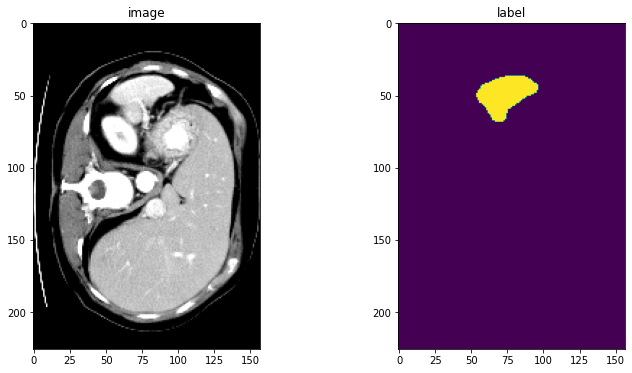

In [13]:
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"][0][0], check_data["label"][0][0])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[:, :, 80])
plt.show()

In [43]:
vol = check_data["image"][0][0]

def frame_args(duration):
    return {
            "frame": {"duration": duration},
            "mode": "immediate",
            "fromcurrent": True,
            "transition": {"duration": duration, "easing": "linear"},
        }

def plotly_3d_figure(volume, number_of_frames, sampling_rate = 2, padding_factor = 10):

    volume = (volume.T*255).float()
    nb_frames = number_of_frames
    frame_ratio = nb_frames/10
    
    original_frames = len(volume)
    frame_subsample_rate = math.ceil(original_frames/nb_frames)
    
    volume = volume[::frame_subsample_rate]

    pad_shape = closest_shapes_up(volume.shape, dims=(1,2),pad_factor = padding_factor)
    volume = pad_ndarray(volume, pad_shape)
    r, c = volume[0].shape
    volume = bin_ndarray(volume, (nb_frames,int(r/sampling_rate),int(c/sampling_rate)))
    r, c = volume[0].shape


    fig = go.Figure(frames=[go.Frame(data=go.Surface(
        z=(frame_ratio - k * 0.1) * np.ones((r, c)),
        surfacecolor=np.flipud(volume[nb_frames - 1 - k]),
        cmin=0, cmax=300
        ),
        name=str(k) # you need to name the frame for the animation to behave properly
        )
        for k in range(nb_frames)])

    # Add data to be displayed before animation starts
    fig.add_trace(go.Surface(
        z=frame_ratio * np.ones((r, c)),
        surfacecolor=np.flipud(volume[nb_frames-1]),
        colorscale='Gray',
        cmin=0, cmax=300,
        colorbar=dict(thickness=20, ticklen=4)
        ))

    sliders = [
                {
                    "pad": {"b": 10, "t": 60},
                    "len": 0.9,
                    "x": 0.1,
                    "y": 0,
                    "steps": [
                        {
                            "args": [[f.name], frame_args(0)],
                            "label": str(k),
                            "method": "animate",
                        }
                        for k, f in enumerate(fig.frames)
                    ],
                }
            ]

    # Layout
    fig.update_layout(
             title='Slices in volumetric data',
             width=500,
             height=500,
             scene=dict(
                        zaxis=dict(range=[-0.1, frame_ratio], autorange=False),
                        aspectmode = 'auto',
                        aspectratio=dict(x=1, y=1, z=1),
                        ),
             updatemenus = [
                {
                    "buttons": [
                        {
                            "args": [None, frame_args(1)],
                            "label": "&#9654;", # play symbol
                            "method": "animate",
                        },
                        {
                            "args": [[None], frame_args(0)],
                            "label": "&#9724;", # pause symbol
                            "method": "animate",
                        },
                    ],
                    "direction": "left",
                    "pad": {"r": 10, "t": 70},
                    "type": "buttons",
                    "x": 0.1,
                    "y": 0,
                }
             ],
             sliders=sliders
    )
    
    return fig

vol = check_data["image"][0][0]
fig = plotly_3d_figure(vol,number_of_frames = 10, sampling_rate = 2)
fig.show()

## Define CacheDataset and DataLoader for training and validation

Here we use CacheDataset to accelerate training and validation process, it's 10x faster than the regular Dataset.  
To achieve best performance, set `cache_rate=1.0` to cache all the data, if memory is not enough, set lower value.  
Users can also set `cache_num` instead of `cache_rate`, will use the minimum value of the 2 settings.  
And set `num_workers` to enable multi-threads during caching.  
If want to to try the regular Dataset, just change to use the commented code below.

In [15]:
train_ds = CacheDataset(
    data=train_files, transform=train_transforms,
    cache_rate=1.0, num_workers=4)
# train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=2, shuffle=True, num_workers=4)

val_ds = CacheDataset(
    data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
# val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=4)

Loading dataset: 100%|███████████████████████████████████████████████████████████████████████████| 9/9 [00:08<00:00,  1.07it/s]


In [16]:
import resource
rlimit = resource.getrlimit(resource.RLIMIT_NOFILE)
resource.setrlimit(resource.RLIMIT_NOFILE, (4096, rlimit[1]))

## Create Model, Loss, Optimizer

In [17]:
UNet_metadata = dict(spatial_dims=3,
    in_channels=1,
    out_channels=2,
    channels=(16, 32, 64, 128, 256),
    strides=(2, 2, 2, 2),
    num_res_units=2,
    norm=Norm.BATCH)

In [18]:
# standard PyTorch program style: create UNet, DiceLoss and Adam optimizer
device = torch.device("cuda:0")
model = UNet(**UNet_metadata).to(device)
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
loss_type = "DiceLoss"
optimizer = torch.optim.Adam(model.parameters(), 1e-4)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [19]:
start = time.time()
aim_run['UNet_metadata'] = UNet_metadata
end = time.time()
time_tracking['UNet_meta_onetime'] += (end - start)

start = time.time()
Optimizer_metadata = {}
for ind, param_group in enumerate(optimizer.param_groups):
    optim_meta_keys = list(param_group.keys())
    Optimizer_metadata[f'param_group_{ind}'] = {key: value for (key, value) in param_group.items() if 'params' not in key}
aim_run['Optimizer_metadata'] = Optimizer_metadata
end = time.time()
time_tracking['optimizer_meta_onetime'] += (end - start)

In [20]:
start = time.time()
model_metadata = track_model_graph(model, input_size=[32, 1, 32, 32, 32])
aim_run['model_graph_metadata'] = model_metadata
end = time.time()
time_tracking['model_graph_meta_onetime'] += (end - start)

/opt/conda/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning:

positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.

/opt/conda/lib/python3.8/site-packages/torch/onnx/symbolic_opset9.py:1684: UserWarning:

Dropout is a training op and should not be exported in inference mode. For inference, make sure to call eval() on the model and to export it with param training=False.



## Execute a typical PyTorch training process

In [21]:
val_interval = 2
best_metric = -1
best_metric_epoch = -1
epoch_loss_values = []
metric_values = []
post_pred = Compose([AsDiscrete(argmax=True, to_onehot=2)])
post_label = Compose([AsDiscrete(to_onehot=2)])

slice_to_track = 80

start = time.time()

for epoch in range(max_epochs):
    print("-" * 10)
    print(f"epoch {epoch + 1}/{max_epochs}")
    model.train()
    epoch_loss = 0
    step = 0
    for batch_data in train_loader:
        step += 1
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = loss_function(outputs, labels)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        print(
            f"{step}/{len(train_ds) // train_loader.batch_size}, "
            f"train_loss: {loss.item():.4f}")
        start = time.time()
        aim_run.track(loss.item() , name = "Batch_Loss", context = {'type':loss_type})
        end = time.time()
        time_tracking['batch_loss'] += (end - start) / max_epochs

    epoch_loss /= step
    epoch_loss_values.append(epoch_loss)
    print(f"epoch {epoch + 1} average loss: {epoch_loss:.4f}")
    
    start = time.time()
    aim_run.track(epoch_loss , name = "Epoch_Loss", context = {'type':loss_type})
    end = time.time()
    time_tracking['epoch_loss'] += (end - start) / max_epochs
    
    if (epoch + 1) % val_interval == 0:
        volumetric_scans_tracked = False
        
        if (epoch + 1) % val_interval*2 == 0:
        
        model.eval()
        with torch.no_grad():
            for index, val_data in enumerate(val_loader):
                val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
                roi_size = (160, 160, 160)
                sw_batch_size = 4
                val_outputs = sliding_window_inference(
                    val_inputs, roi_size, sw_batch_size, model)
                
                #Tracking greyscale properly
                output = torch.argmax(val_outputs, dim=1)[0, :, :, slice_to_track].float()
                #Alternative Method
                # output = (torch.argmax(val_outputs, dim=1)[0, :, :, 80] * 255).cpu().numpy().astype(np.uint8)
                
                start = time.time()
                aim_run.track(aim.Image(val_inputs[0, 0, :, :, slice_to_track], \
                        caption=f'Input Image: {index}'), \
                        name = 'Validation',  context = {'type':'Input'})

                aim_run.track(aim.Image(val_labels[0, 0, :, :, slice_to_track], \
                                        caption=f'Label Image: {index}'), \
                               name = 'Validation',  context = {'type':'Label'})

                aim_run.track(aim.Image(output,caption=f'Predicted Label: {index}'), \
                               name = 'Predictions',  context = {'type':'labels'}) 
                end = time.time()
                time_tracking['val_2d'] += (end - start) / max_epochs
                print("tracked images")
         
    
                if (epoch + 1) % val_interval*2 == 0 and not volumetric_scans_tracked:
                    start = time.time()
                    fig_raw = plotly_3d_figure(val_inputs[0][0],number_of_frames = 101, sampling_rate = 5)
                    fig_label = plotly_3d_figure(val_labels[0][0],number_of_frames = 101, sampling_rate = 5)
                    end = time.time()
                    time_tracking['plotly'] += (end - start) / max_epochs
                    
                    start = time.time()
                    aim_run.track(aim.Figure(fig_raw), name='Volumetric Validation', context={'Inputs':'Raw'})
                    aim_run.track(aim.Figure(fig_label), name='Volumetric Validation', context={'Inputs':'label'})
                    aim_run.track(aim.Figure(fig), name='Volumetric Validation', context={'Predictions':'label'})
                    print("tracked Plotly")
                    end = time.time()
                    time_tracking['val_3d'] += (end - start) / max_epochs
                    
                    volumetric_scans_tracked = True

            
    

                
                val_outputs = [post_pred(i) for i in decollate_batch(val_outputs)]
                val_labels = [post_label(i) for i in decollate_batch(val_labels)]
                # compute metric for current iteration
                dice_metric(y_pred=val_outputs, y=val_labels)

            # aggregate the final mean dice result
            metric = dice_metric.aggregate().item()
            start = time.time()
            aim_run.track(metric , name = "Val_metric", context = {'type':loss_type})
            end = time.time()
            time_tracking['val_metric'] += (end - start) / max_epochs
            volumetric_scans_tracked = False

            
            # reset the status for next validation round
            dice_metric.reset()
            

            metric_values.append(metric)
            if metric > best_metric:
                start1 = time.time()
                aim_run["best_metric"] = metric
                end1 = time.time()
                best_metric = metric
                best_metric_epoch = epoch + 1
                torch.save(model.state_dict(), os.path.join(
                    root_dir, "best_metric_model.pth"))
                start2 = time.time()
                best_model_log_message = f"saved new best metric model at the {epoch+1}th epoch"
                aim_run.track(aim.Text(best_model_log_message), name = f'best_model_log_message', epoch=epoch+1)
                end2 = time.time()
                time_tracking['best_metric_update'] += (end1 - start1 + end2 - start2) / max_epochs
                print(best_model_log_message)
            
            start = time.time()
            message1 = f"current epoch: {epoch + 1} current mean dice: {metric:.4f}"
            message2 = f"\nbest mean dice: {best_metric:.4f} "
            message3 = f"at epoch: {best_metric_epoch}"
            aim_run.track(aim.Text(message1 +"\n" + message2 + message3), name = f'Epoch Summary', epoch=epoch+1)
            print(message1, message2, message3)
            end = time.time()
            time_tracking['epoch_msg'] += (end - start) / max_epochs

----------
epoch 1/10
1/16, train_loss: 0.6764
2/16, train_loss: 0.6668
3/16, train_loss: 0.6652
4/16, train_loss: 0.6722
5/16, train_loss: 0.6516
6/16, train_loss: 0.6677
7/16, train_loss: 0.6541
8/16, train_loss: 0.6686
9/16, train_loss: 0.6717
10/16, train_loss: 0.6597
11/16, train_loss: 0.6411
12/16, train_loss: 0.6550
13/16, train_loss: 0.6427
14/16, train_loss: 0.6479
15/16, train_loss: 0.6413
16/16, train_loss: 0.6506
epoch 1 average loss: 0.6583
----------
epoch 2/10
1/16, train_loss: 0.6439
2/16, train_loss: 0.6366
3/16, train_loss: 0.6388
4/16, train_loss: 0.6130
5/16, train_loss: 0.6187
6/16, train_loss: 0.6046
7/16, train_loss: 0.6183
8/16, train_loss: 0.6147
9/16, train_loss: 0.6363
10/16, train_loss: 0.6235
11/16, train_loss: 0.6031
12/16, train_loss: 0.6339
13/16, train_loss: 0.6450
14/16, train_loss: 0.6373
15/16, train_loss: 0.6273
16/16, train_loss: 0.6241
epoch 2 average loss: 0.6262
tracked param dists
tracked gradient dists
tracked images
tracked Plotly
tracked ima

In [22]:
print(
    f"train completed, best_metric: {best_metric:.4f} "
    f"at epoch: {best_metric_epoch}")

train completed, best_metric: 0.0980 at epoch: 10


# Opening Aim UI

At this point, you can open up the Aim UI to visualize results. For best results, open a terminal in the same environment and run `aim up &`, then follow the link (e.g., `http://127.0.0.1:43800`) to see the Aim interface.

If you get an error saying "address already in use," you may have attempted to open up Aim multiple times. In that case, you can specify a different port number using `aim up --port xxxxx &`.

The command below opens the Aim UI right here in the notebook, but we recommend the procedure above for ease of use.

In [31]:
# %load_ext aim
# %aim up

In [35]:
{key:val for key, val in sorted(time_tracking.items(), key=lambda item: item[1], reverse=True)}

{'val_3d': 0.33675045967102046,
 'plotly': 0.25978713035583495,
 'model_graph_meta': 0.2558314800262451,
 'param_dists': 0.10122356414794922,
 'grad_dists': 0.09103083610534668,
 'val_2d': 0.0546680450439453,
 'batch_loss': 0.01371347904205322,
 'hyperparams': 0.007508516311645508,
 'epoch_loss': 0.0009012699127197264,
 'val_metric': 0.0004669666290283203,
 'best_metric_update': 0.00045454502105712896,
 'epoch_msg': 0.00042629241943359375,
 'UNet_meta': 8.327960968017578e-05,
 'optimizer_meta': 7.617473602294922e-05}

## Plot the loss and metric

In [ ]:
plt.figure("train", (12, 6))
plt.subplot(1, 2, 1)
plt.title("Epoch Average Loss")
x = [i + 1 for i in range(len(epoch_loss_values))]
y = epoch_loss_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.subplot(1, 2, 2)
plt.title("Val Mean Dice")
x = [val_interval * (i + 1) for i in range(len(metric_values))]
y = metric_values
plt.xlabel("epoch")
plt.plot(x, y)
plt.show()

## Check best model output with the input image and label

In [ ]:
model.load_state_dict(torch.load(
    os.path.join(root_dir, "best_metric_model.pth")))
model.eval()
with torch.no_grad():
    for i, val_data in enumerate(val_loader):
        roi_size = (160, 160, 160)
        sw_batch_size = 4
        val_outputs = sliding_window_inference(
            val_data["image"].to(device), roi_size, sw_batch_size, model
        )
        # plot the slice [:, :, 80]
        plt.figure("check", (18, 6))
        plt.subplot(1, 3, 1)
        plt.title(f"image {i}")
        plt.imshow(val_data["image"][0, 0, :, :, 80], cmap="gray")
        plt.subplot(1, 3, 2)
        plt.title(f"label {i}")
        plt.imshow(val_data["label"][0, 0, :, :, 80])
        plt.subplot(1, 3, 3)
        plt.title(f"output {i}")
        plt.imshow(torch.argmax(
            val_outputs, dim=1).detach().cpu()[0, :, :, 80])
        plt.show()
        if i == 2:
            break

## Cleanup data directory

Remove directory if a temporary was used.

In [32]:
if directory is None:
    shutil.rmtree(root_dir)